In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {
                'size'   : 20}
matplotlib.rc('font', **font)
plt.rc('legend',fontsize=12)

In [2]:
#Constants:
emass_to_pmass = 1836.152673
erest_mass = 0.510998e6 # eV
hbarc = 0.1973269804e-6 # ev m
fineconst =  0.0072973525693

In [3]:
def beta_ev(electron_energy):
    """electron_energy : electron energy in units of eV"""
    return np.sqrt(1.0-1.0/(1+electron_energy/erest_mass)**2)

In [4]:
def t_max(electron_energy,Mass_of_Atom):
    part1 = 2*electron_energy*(electron_energy+2*erest_mass)
    part2 = erest_mass*(Mass_of_Atom*emass_to_pmass+2+1/(Mass_of_Atom*emass_to_pmass))\
            +2*electron_energy
    return part1/part2
def trasnferred_energy(electron_energy,Mass_of_Atom,theta):
    return t_max(electron_energy, Mass_of_Atom)*np.sin(theta/2.0)**2

In [5]:
def rutherford_xsection(Z,electron_energy,theta):
    beta = beta_ev(electron_energy)
    part1 = (Z*fineconst*hbarc/(2*erest_mass))**2
    part2 = (1-beta**2)/(beta*np.sin(theta/2))**4
    return part1*part2
def coupling(Z,electron_energy,theta):
    beta = beta_ev(electron_energy)
    return 1- beta**2*np.sin(theta/2)**2+np.pi*Z*fineconst*beta*np.sin(theta/2)\
            *(1-np.sin(theta/2))

def scatter_xsection(Z,electron_energy,theta):
    return rutherford_xsection(Z,electron_energy,theta)*coupling(Z,electron_energy,theta)

In [6]:
def threshold_min(Z):
    """
    This is a table function for minimum displacement threshold energies for various elements found in literature
    default value set to 10
    """
    if ( Z == 79):
        return 15*.8
    if ( Z == 6):
        return 16.52*0.9
    if ( Z == 16):
        return 4
    return 10
def theta_min(Tmax, Tmin):
    #print(Tmin,T_max)
    c=np.where(Tmax>Tmin ,np.sqrt(Tmin/Tmax), 0)
    return 2*np.arcsin(c)

In [121]:
def total_xsection(Mass,Z,electron_energy):
    Tmax = t_max(electron_energy,Mass)
    print('Tmax :',Tmax)
    Threshold_min = threshold_min(Z)
    print('Threshold min',Threshold_min)

    Theta_min = theta_min(Tmax,Threshold_min)
    print('Theta_min:',Theta_min*180/np.pi)
    theta = np.linspace(Theta_min,np.pi,num=20)
    c = np.sin(theta)*scatter_xsection(Z,electron_energy,theta)
    d = np.where(Theta_min > 0,2*np.pi*np.trapz(c,theta),0)
    return d
def xsection_theta_min_to_theta(Mass,Z,electron_energy,theta):
    Tmax = t_max(electron_energy,Mass)
    print('Tmax :',Tmax)
    Threshold_min = threshold_min(Z)
    print('Threshold min',Threshold_min)

    Theta_min = theta_min(Tmax,Threshold_min)
    print('Theta_min:',Theta_min*180/np.pi)
    thetas = np.linspace(Theta_min,theta,num=20)
    c = np.sin(thetas)*scatter_xsection(Z,electron_energy,thetas)
    d = np.where(Theta_min > 0,2*np.pi*np.trapz(c,thetas),0)
    return d
def total_emission_xsection(Mass,Z,electron_energy):
    beta = beta_ev(electron_energy)
    gamma = np.pi*4*(Z*fineconst*hbarc/(2*erest_mass))**2*(1-beta**2)/beta**4
    Tmax= t_max(electron_energy,Mass)
    Tmin = threshold_min(Z)
    q = Tmax/Tmin
    q = np.where(Tmax/Tmin > 1.0 , q,1)
    #print('Tmax/Tmin' ,q)
    coupling =  q - 1 - beta**2*np.log(q) + np.pi*Z*fineconst*beta*(2*np.sqrt(q)-np.log(q)-2)
    return gamma*coupling
def integrate(Z,Mass,electron_energy):
    Threshold = threshold_min(Z)
    tmax = t_max(electron_energy=electron_energy,Mass_of_Atom=Mass)
    thetamin = np.where(tmax > Threshold, theta_min(tmax,Threshold), np.pi)
    thetas = np.linspace(thetamin,np.pi,num=100)
    t=np.trapz(scatter_xsection(Z,electron_energy=electron_energy,theta=thetas)*\
             np.sin(thetas)*2*np.pi,thetas)
    return t
def scattering_probability(Z, Mass, electron_energy):
    """
    Returns an array of size 100 which gives the probability distribution
    between Theta_min - Pi
    If Maximum Transferred energy is lower than Threshold energy then returns array of zeros
    """
    trf_max = t_max(Mass_of_Atom=Mass,electron_energy=electron_energy)
    thrs = threshold_min(Z=Z)
    nsamples= 100000
    if  trf_max < thrs :
        return np.zeros(nsamples),np.zeros(nsamples),np.zeros(nsamples),0.0
    else:
        thetamin = theta_min(Tmax=trf_max,Tmin=thrs)
        total_xsection = integrate(Z=Z,Mass=Mass,electron_energy=electron_energy)
        print('Total cross section',total_xsection*1e28)
        print('Minimum Scattering Angle :' , thetamin)
        thetas ,dtheta = np.linspace(thetamin,np.pi,num=nsamples,retstep=True)
        dist_func = scatter_xsection(Z,electron_energy,thetas)*2.0*np.pi*np.sin(thetas)/total_xsection
        probability_function = np.cumsum(dist_func)*dtheta

        return thetas,dist_func,probability_function,total_xsection
               #2.0*np.pi*np.sin(thetas)*/total_xsection
        
    

In [134]:
# Testing McKinley Feschbach Formula for Carbon atom
# With Electron Energy ranging from 1eV to 400keV
Z_carbon = 6 # Carbon Nuclear Charge
M_carbon = 12.011 # Mass of Carbon Atom
Z_sulfur = 16
M_sulfur = 32
e_energies = np.linspace(1e3,100e3,num=10)
# Threshold Energy for Carbon is set to 16.5*0.9
Thrs_min = threshold_min(Z=Z_sulfur)
print('Threshold Energy is %8.2f'%Thrs_min)
txs =[]
theta_mins = []
prob_plots=[]
for e in e_energies:
    trf_max = t_max(Mass_of_Atom=M_sulfur,electron_energy=e)
    print('Energy of Incident Electron : %8.4f keV' % (e*1e-3))
    print('   Maximum transferred energy to sulfur is %8.2f eV'% (trf_max))
    tht_min = theta_min(Tmax=trf_max, Tmin=Thrs_min)
    print('   Theta_min is                            %8.2f degrees'%
          (tht_min*180./np.pi)) 
    theta_mins.append(tht_min*180./np.pi)
    tx = integrate(Z=Z_sulfur,Mass=M_sulfur,electron_energy=e)
    print('   Total Cross section is                  %8.2f barns ' % (tx*1e28))
    thetas,dist_func,prob_func,dumb = scattering_probability(Z=Z_sulfur,Mass=M_sulfur,electron_energy=e)
    data = np.asarray((thetas,dist_func,prob_func))
    prob_plots.append(data)
    print(data)
    txs.append(tx)
txs = np.asarray(txs)
theta_mins = np.asarray(theta_mins)
prob_plots = np.asarray(prob_plots)
print(theta_mins)

Threshold Energy is     4.00
Energy of Incident Electron :   1.0000 keV
   Maximum transferred energy to sulfur is     0.07 eV
   Theta_min is                                0.00 degrees
   Total Cross section is                      0.00 barns 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Energy of Incident Electron :  12.0000 keV
   Maximum transferred energy to sulfur is     0.83 eV
   Theta_min is                                0.00 degrees
   Total Cross section is                      0.00 barns 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Energy of Incident Electron :  23.0000 keV
   Maximum transferred energy to sulfur is     1.60 eV
   Theta_min is                                0.00 degrees
   Total Cross section is                      0.00 barns 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Energy of Incident Electron :  34.0000 keV
   Maximum transferred energy to sulfur is     2.

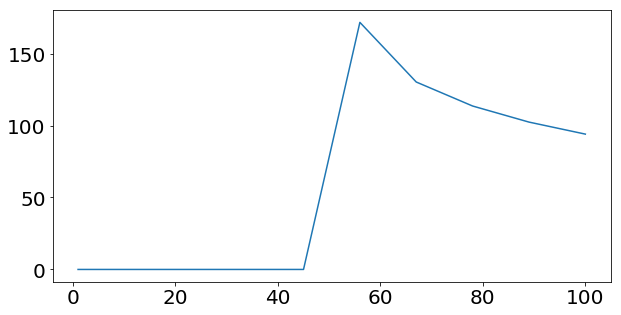

10
[0. 0. 0. ... 0. 0. 0.]


In [135]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(e_energies/1e3,theta_mins)
plt.show()
print(len(prob_plots))
print(prob_plots[1][0,:])


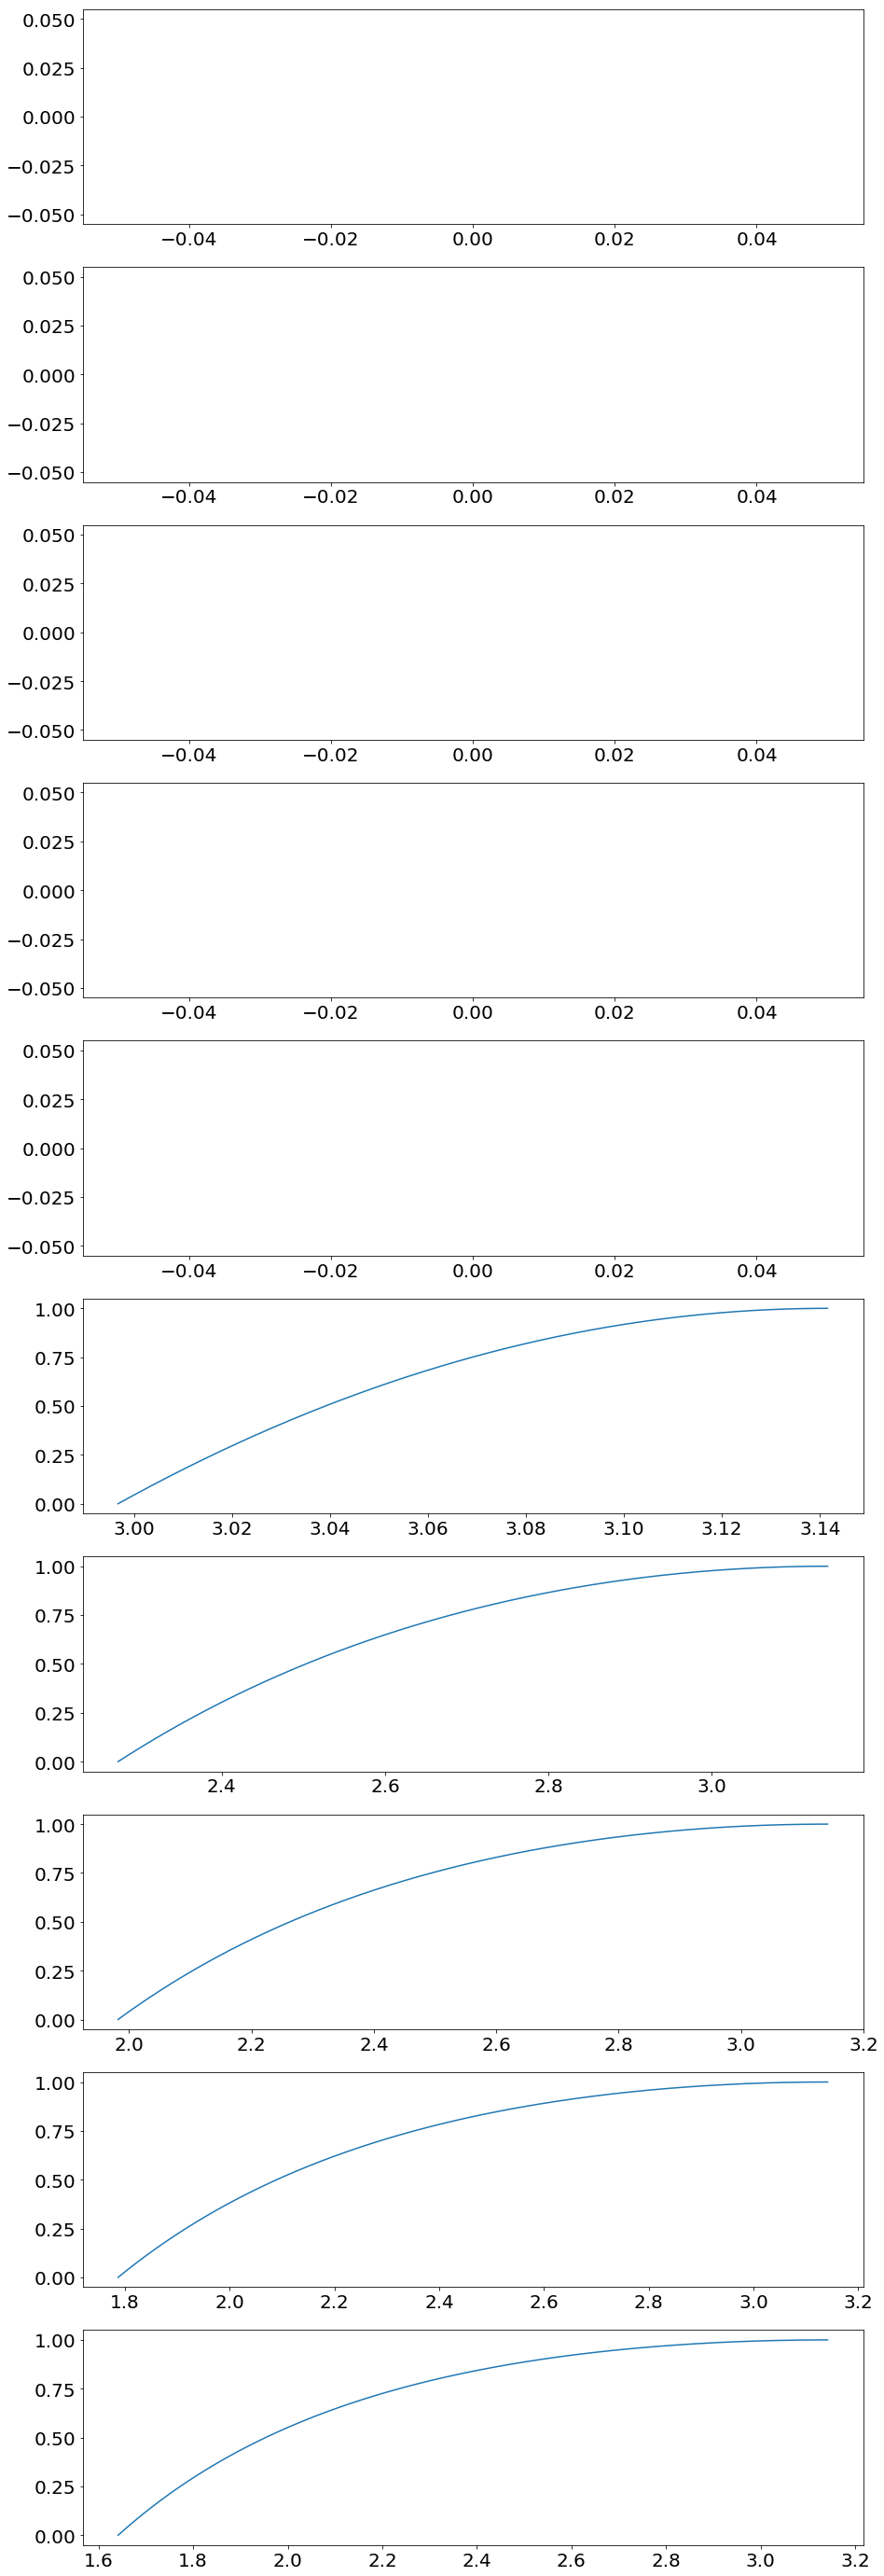

In [137]:
fig, ax = plt.subplots(len(prob_plots),1,figsize=(15,50))
for i,data in enumerate(prob_plots):
    ax[i].plot(data[0,:],data[2,:])
plt.show()

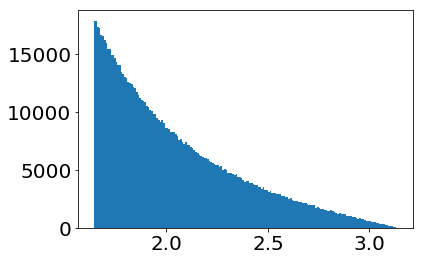

In [138]:
from random import choices
population = prob_plots[9][0,:]
weights = prob_plots[9][1,:]
rns=choices(population,weights,k=1000000)
histo = np.histogram(rns,bins=90)
fig, ax = plt.subplots()
ax.hist(rns,bins=180)
plt.show()

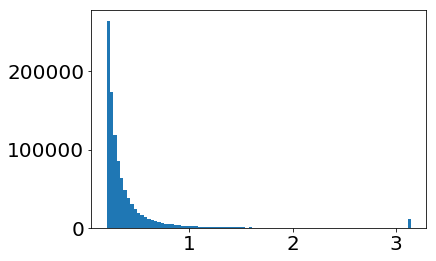

In [127]:
thetas=[]
for i in range(1000000):
    rn = np.random.random()
    idx =(np.abs(prob_plots[9][1,:]-rn).argmin())
    thetas.append(prob_plots[9][0,idx])
histo = np.histogram(thetas,bins=90)
fig,ax = plt.subplots()
ax.hist(thetas,bins=90)
plt.show()

Total cross section 4.9538823952636815
Minimum Scattering Angle : 2.6479446657629553


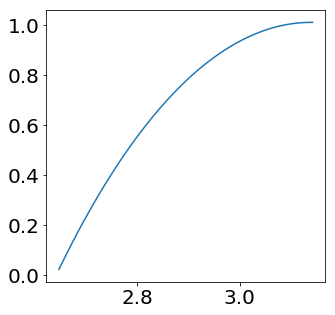

0.6158327763931661
0.6119247202951089 2.822466681661332
Atom Emission Angle = 9.14 , Omega = 252.72 


In [43]:
thetas,dist_func,prob_func,total_xsection = scattering_probability(Z=Z_carbon,Mass=M_carbon,electron_energy=80.8e3)
fig, ax = plt.subplots(figsize=(5,5))
#ax.plot(thetas,probs)
#ax.plot(thetas,dist_func)
ax.plot(thetas,prob_func)
plt.show()

#print(thetas,prob_func)
#print(np.sum(probs))
#for t,xsc in zip(thetas,probs):
#    print(t,xsc*1e28,total_xsection*1e28,xsc*np.sin(t)*np.pi*2*1e28)
#
#    
#    
s = 0
#
for t,xsc,p in zip(thetas,dist_func,prob_func):
    s = s+ (thetas[1]-thetas[0])*xsc
    #print(s,p)
rn = np.random.random()
print(rn)
idx =(np.abs(prob_func-rn).argmin())
print(prob_func[idx],thetas[idx])
rn = np.random.uniform(0,2*np.pi)
Omega = (np.pi-thetas[idx])/2
print('Atom Emission Angle = %4.2f , Omega = %4.2f '%(Omega*180/np.pi,rn*180/np.pi))

In [21]:
Z = 6
Mass = 12.011
Threshold = Threshold_min(Z)
#eenergies = np.linspace(10,400e3,num=20)
#sigmas = total_xsection(Mass=Mass,Z=Z,electron_energy=eenergies)
eenergy=100e3
thetamin = theta_min(t_max(electron_energy=eenergy,Mass_of_Atom=Mass),Threshold)
print(thetamin,np.pi)
theta = np.pi
thetas = np.linspace(thetamin,np.pi,num=1000)
sigmas = []
sigmathetas =[]
total= 0
totals =[]
for theta in thetas:
    sigma = scatter_xsection(Z,electron_energy=eenergy,theta=theta)
    sigmas.append(sigma)
    sigmatheta = sigma*np.pi*2*np.sin(theta)
    sigmathetas.append(sigmatheta)
    total = total + sigmatheta*(thetas[8]-thetas[7])
    totals.append(total)
    #print('---',sigma,sigmatheta,total*1e28)
sigmas = np.asarray(sigmas)
sigmathetas = np.asarray(sigmathetas)
totals = np.asarray(totals)

#t=np.trapz(scatter_xsection(Z,electron_energy=eenergy,theta=thetas)*np.sin(thetas)*2*np.pi,thetas)
energies = np.linspace(55e3,400e3,num=10)
xs=[]
for e in energies:
    print( integrate(Z=Z,Mass=Mass,electron_energy=e)*1e28)
    xs.append(integrate(Z=Z,Mass=Mass,electron_energy=e)*1e28)
print(t*1e28,totals[-1]*1e28)
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(thetas,totals*1e28)
ax[1].plot(energies/1e3,xs)
plt.show()

NameError: name 'Threshold_min' is not defined

In [260]:
#Gold Atom
#Mass = 196
#Z = 79
Z = 6
Mass = 12.011
Threshold = Threshold_min(Z)
eenergies = np.linspace(10,2e6,num=200)
ecratios = beta_ev(eenergies)
angles = np.linspace(np.pi/100,np.pi,num=200)
xsections = scatter_xsection(Z,1e6,angles)
een = 90e3 
Tmax = t_max(een,Mass)
print('Max Transferred Energy %10.4f'% Tmax)
t_min = theta_min(Tmax, threshold_min(Z))
print('Minimum Theta %10.4f degrees :' %(t_min*180/np.pi))
tx = total_xsection(Mass,Z,een)
print(tx)
print('Total Cross Section %10.4f in barns ' %(tx*1e28))
te = total_emission_xsection(Mass=12.011,Z=6,electron_energy=83e3)
print(te*1e28)
te = total_emission_xsection(Mass=12.011,Z=6,electron_energy=200e3)
print(te*1e28)
ees = np.linspace(1e3,400e3,num=2000)
tes = total_emission_xsection(Mass=12.011, Z=6, electron_energy=ees)

Max Transferred Energy    17.7592
Minimum Theta   149.1147 degrees :
4.739699280398401e-28
Total Cross Section     4.7397 in barns 
0.0
23.56943291723923


In [254]:
eens = np.linspace(80e3,400e3,num=100)
txs = []
#print(txs)
for en in eens:
    txs.append(total_xsection(Mass,Z,en))
txs = np.asarray(txs)

/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


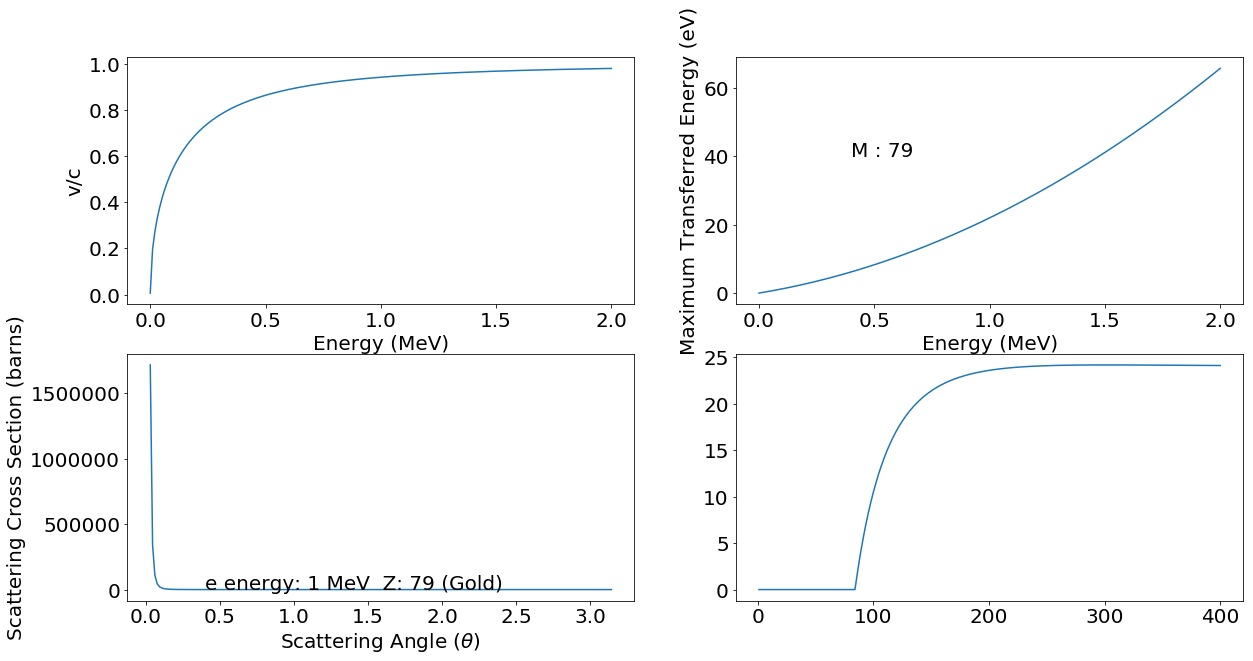

In [255]:
x = np.linspace(0,1e6,num=200)
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(eenergies/1e6,ecratios)
ax[0,0].set_xlabel('Energy (MeV)')
ax[0,0].set_ylabel('v/c')
ax[0,1].plot(eenergies/1e6,tmaxs)
ax[0,1].set_xlabel('Energy (MeV)')
ax[0,1].set_ylabel('Maximum Transferred Energy (eV)')
ax[0,1].annotate('M : 79',xy=(0.4,40))
ax[1,0].plot(angles,xsections*1e28)
ax[1,0].set_xlabel('Scattering Angle ($\\theta$)')
ax[1,0].set_ylabel('Scattering Cross Section (barns)')
ax[1,0].annotate('e energy: 1 MeV  Z: 79 (Gold)',xy=(0.4,40))
ax[1,1].plot(ees/1e3,tes*1.0e28)
plt.show()

In [ ]:
X= np.random.uniform(0,10,10)
Y= np.random.uniform(0,10,10)
X[0]=1.9
Y[0]=0.1
X[1]=26.1
xlo = 0
xhi = 25.2
ylo = 0
yhi = 21.82
lx = xhi - xlo
ly = yhi - ylo

deltax = lx/8.0
deltay = ly/8.0
xbin = np.arange(1,8)*deltax+xlo
ybin = np.arange(1,8)*deltay+ylo
xt = np.where(3<X < 4, X,X-lx)
xt = np.where(xt > xlo,xt,xt+lx)
Xd = np.digitize(xt,xbin,right=False)
Yd = np.digitize(Y,ybin,right=False)
xy=np.dstack((Xd,Yd))
print(deltax,deltay)
print(xbin)
print(ybin)

In [76]:
for x,y,xd,yd in zip(X,Y,Xd,Yd):
    print(x,y,xd,yd)



1.9 0.1 0 0
26.1 3.2476907836137325 0 1
6.210082142208353 9.716906639255898 1 3
1.8914971344480103 1.5627443565869326 0 0
7.611939188229497 5.498991193666589 2 2
5.832208107771166 7.188567791466689 1 2
2.0485951352187692 9.200269087213243 0 3
0.7125903903999498 6.0943992691189495 0 2
9.361384668266533 8.71674440623671 2 3
9.994113661066269 3.4218686228640784 3 1


In [147]:
A= np.argwhere((Xd == 1) &( Yd == 7))
A

array([[0],
       [5]])

In [2]:
typeorder='Al O S H'
typeorder.split(' ')

['Al', 'O', 'S', 'H']

In [112]:
2*np.arcsin(0.1)

0.2003348423231196